---



---

# Predição de partido político baseado em votações

Este notebook implementa uma rede neural para predizer (descobrir) qual partido político de um congressista americano com base nos seus votos.

Utiliza-se um conjunto de dados públicos de como os congressistas dos EUA votaram em 17 questões diferentes. 

Nos Estados Unidos há dois principais partidos políticos: "Democrata" e "Republicano". Nos tempos modernos, eles representam ideologias progressistas e conservadoras, respectivamente.

Trata-se de um problema de classificação binária.


---



---

## Conjunto de dados

Arquivo: **votes_data.txt**:

1. Banco de dados de registros de votação do Congresso dos Estados Unidos de 1984

2. Informações da fonte:
    * Fonte: Congressional Quarterly Almanac, 98º Congresso,
                 2ª sessão 1984, Volume XL: Congressional Quarterly Inc.
                 Washington, D.C., 1985.
    * Doador: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    * Data: 27 de abril de 1987

3. Uso anterior
   - Publicações
     1. Schlimmer, J. C. (1987). Aquisição de conceito através de
        ajuste representacional. Tese de doutorado, Departamento de
        Informação e Ciência da Computação, Universidade da Califórnia, Irvine, CA.
        - Resultados: cerca de 90% -95% de precisão parece ser a assíntota de STAGGER
        - Atributo previsto: afiliação partidária (2 classes)

4. Número de instâncias: 435 (267 democratas, 168 republicanos)

5. Número de atributos: 16 + nome da classe/partido = 17 (todos com valor booleano)

6. Informação de Atributo:
   1. Nome da classe: (democrata, republicano)
   2. Crianças deficientes: (y, n)
   3. Compartilhamento de custos do projeto de água: (y, n)
   4. Resolução de adoção do orçamento: (y, n)
   5. Congelamento de honorários médicos: (y, n)
   6. Ajuda El Salvador: (y, n)
   7. Grupos religiosos nas escolas: (y, n)
   8. Proibição de teste anti-satélite: (y, n)
   9. Ajuda para contras nicaraguenses: (y, n)
  10. Míssil Mx: (y, n)
  11. Imigração: (y, n)
  12. Corte de corporação de combustíveis Syn: (y, n)
  13. Gastos com educação: (y, n)
  14. Super fundo direto: (y, n)
  15. Crime: (y, n)
  16. Exportações com isenção de impostos: (y, n)
  17. Exportação África do Sul: (y, n)



## Leitura e preparação dos dados

Vamos começar importando o arquivo CSV bruto usando o Pandas e fazer um DataFrame dele inserindo rótulos (nomes) em cada coluna (atributo)

In [21]:
import pandas as pd

# Clone do repositório de dados do GitHub
!git clone https://github.com/malegopc/AM2PUCPOC
# cria vetor com os rótulos de cada atributo
nomes_atributos = ['Partido', 'Crianças deficientes', 'Compartilhamento de custos do projeto de água',
                    'Resolução de adoção do orçamento', 'Congelamento de honorários médicos',
                    'Ajuda El Salvador', 'Grupos religiosos nas escolas',
                    'Proibição de teste anti-satélite', 'Ajuda a contras nicaraguenses',
                    'Míssil MX', 'Imigração', 'Corte de corporação de combustíveis Syn',
                    'Gastos com educação', ' Super fundo direto', 'Crime',
                    'Exportações isentas de impostos', 'Exportação África do Sul']

# lê arquivo de dados, atribue NaN para dados faltantes e rótulos em cada coluna
dados_votacao = pd.read_csv('/content/AM2PUCPOC/Datasets/Predicao_Politica/votes_data.txt', na_values=['?'], names = nomes_atributos)
# imprime as 5 primeiras linha dos dados montados
dados_votacao.head()

fatal: destination path 'AM2PUCPOC' already exists and is not an empty directory.


,Partido,Crianças deficientes,Compartilhamento de custos do projeto de água,Resolução de adoção do orçamento,Congelamento de honorários médicos,Ajuda El Salvador,Grupos religiosos nas escolas,Proibição de teste anti-satélite,Ajuda a contras nicaraguenses,Míssil MX,Imigração,Corte de corporação de combustíveis Syn,Gastos com educação,Super fundo direto,Crime,Exportações isentas de impostos,Exportação África do Sul
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


## Análise (estatística) descritiva dos dados

Análise descritiva dos dados (resumo).

In [22]:
dados_votacao.describe()

,Partido,Crianças deficientes,Compartilhamento de custos do projeto de água,Resolução de adoção do orçamento,Congelamento de honorários médicos,Ajuda El Salvador,Grupos religiosos nas escolas,Proibição de teste anti-satélite,Ajuda a contras nicaraguenses,Míssil MX,Imigração,Corte de corporação de combustíveis Syn,Gastos com educação,Super fundo direto,Crime,Exportações isentas de impostos,Exportação África do Sul
count,435,423,387,424,424,420,424,421,420,413,428,414,404,410,418,407,331
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269


## Número de instâncias

In [23]:
len(dados_votacao)

435

## Eliminação de dados ausentes 

Alguns políticos se abstiveram em algumas votações ou simplesmente não estavam presentes no momento da votação. Para contornar esse problema vamos simplesmente eliminar as linhas com dados ausentes para mantê-lo simples, mas na prática é importante ter certeza de que isso não introduziu nenhum tipo de viés em sua análise (se uma parte se abstiver mais do que outra, isso poderia ser problemático)


In [24]:
# Remove dados faltantes na própria variável 
dados_votacao.dropna(inplace=True)
dados_votacao.describe()

,Partido,Crianças deficientes,Compartilhamento de custos do projeto de água,Resolução de adoção do orçamento,Congelamento de honorários médicos,Ajuda El Salvador,Grupos religiosos nas escolas,Proibição de teste anti-satélite,Ajuda a contras nicaraguenses,Míssil MX,Imigração,Corte de corporação de combustíveis Syn,Gastos com educação,Super fundo direto,Crime,Exportações isentas de impostos,Exportação África do Sul
count,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,democrat,n,n,y,n,y,y,y,y,n,y,n,n,y,y,n,y
freq,124,136,125,123,119,128,149,124,119,119,128,152,124,127,149,146,189


## Número de instâncias após eliminação de dados faltantes

In [25]:
len(dados_votacao)

232

## Transforma dados categóricos (y e n) em números (1 e 0) 

In [26]:
dados_votacao.replace(('y', 'n'), (1, 0), inplace=True)
dados_votacao.replace(('democrat', 'republican'), (1, 0), inplace=True)
dados_votacao.head()

,Partido,Crianças deficientes,Compartilhamento de custos do projeto de água,Resolução de adoção do orçamento,Congelamento de honorários médicos,Ajuda El Salvador,Grupos religiosos nas escolas,Proibição de teste anti-satélite,Ajuda a contras nicaraguenses,Míssil MX,Imigração,Corte de corporação de combustíveis Syn,Gastos com educação,Super fundo direto,Crime,Exportações isentas de impostos,Exportação África do Sul
5,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
8,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
19,1,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1
23,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
25,1,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1


## Separa os atributos das classes

Extrai os atributos e as classes (rótulos) colocando-os em duas variáveis separadas (na forma que o Keras espera).

In [27]:
X = dados_votacao[nomes_atributos].drop('Partido', axis=1).values
y = dados_votacao['Partido'].values
print(X.shape)
print(y.shape)

(232, 16)
(232,)


## Divide o conjunto de dados em treino e teste

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
print(X_train.shape)
print(X_test.shape)

(174, 16)
(58, 16)


## Criação do modelo de rede neural


In [29]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import cross_val_score

model = Sequential()
# 1a. camada escondida com 32 neurônios - 16 entradas (atributos)
model.add(Dense(32, input_dim=16, kernel_initializer = 'he_uniform', activation='relu'))
# 2a. camada escondida com 16 neurônios
model.add(Dense(16, kernel_initializer = 'he_uniform', activation='relu'))
# Camada de saída com 01 neurônio - Classificação binária (Democrat or Republican)
model.add(Dense(1, activation='sigmoid'))
# Sumário do modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


## Compila o modelo

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Treina o modelo

In [31]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta = 1e-10, patience=5, restore_best_weights = 'True', verbose=1)
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), batch_size=8, epochs=100, callbacks=[early_stop])

Epoch 1/100
22/22 [==============================] - 1s 15ms/step - loss: 0.4927 - accuracy: 0.8377 - val_loss: 0.3895 - val_accuracy: 0.9310
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.3916 - accuracy: 0.8910 - val_loss: 0.3052 - val_accuracy: 0.9483
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.3188 - accuracy: 0.8918 - val_loss: 0.2489 - val_accuracy: 0.9828
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.8785 - val_loss: 0.2071 - val_accuracy: 0.9828
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2271 - accuracy: 0.9293 - val_loss: 0.1828 - val_accuracy: 0.9828
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2095 - accuracy: 0.9039 - val_loss: 0.1666 - val_accuracy: 0.9828
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.2250 - accuracy: 0.9113 - val_loss: 0.1571 - val_accuracy: 0.9828
Epoch 8/100


In [32]:
# history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

## Análise da função *loss* (erro/perda)
Vamos observar o comportamento da função *loss* para os dados de treino e de validação/teste.

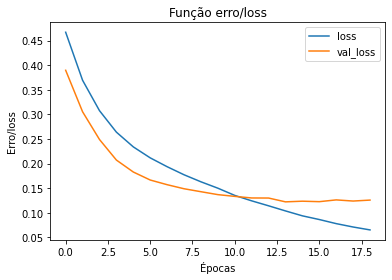

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Épocas")
plt.ylabel('Erro/loss')
plt.title('Função erro/loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Análise da métrica de desempenho (acurácia)
Vamos observar o desempenho (acurácia) da rede para os dados de treino e de validação/teste.

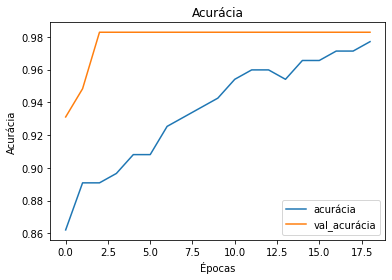

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Épocas")
plt.ylabel('Acurácia')
plt.title('Acurácia')
plt.legend(['acurácia', 'val_acurácia'])
plt.show()

## Classifica os dados de teste

In [35]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

## Calcula a matriz de confusão sobre os dados de teste

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[30  1]
 [ 0 27]]


## Classifica o conjunto de dados inteiro

In [37]:
y_pred2 = model.predict(X)
y_pred2 = (y_pred2 > 0.5)

## Calcula a matriz de confusão sobre o conjunto inteiro de dados

In [38]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y, y_pred2)
print(cm2)

[[105   3]
 [  4 120]]


In [39]:
import numpy as np
print(np.around(model.predict(X[:5,:])))

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [40]:
x1 = np.array([X[0]])
pred = model.predict(x1)
print(type(pred)) # array numpy
print(pred)
print(round(pred[0][0]))

<class 'numpy.ndarray'>
[[0.88483906]]
1
